# Filter a Kr kDST to validate the selection
### JAH 03/08/18

<i>
This notebook takes a kDST, applies a selection to identify the Kr candidates, monitor the variables.
It can store the filter dst.
</i>

<i>
In presence of external gamma sources, the XR production
is very significative and constitutes a source of
background for Kr data. This NB filters the data to
produce a rather pure dataset on which to perform
the regular analysis.
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Aug  7 11:06:09 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number            = 6267
path                  = f"$IC_DATA/kdsts"
tag                   = 'trigger1_v0.9.9_20180802'
subrun                = 0
file_range            = file_range  = (10000*subrun, 10000*(subrun+1))

output_dst_filename   = f"$IC_DATA/dsts/kdst_{run_number}_{subrun}_filtered.h5"

# bootstrap corrections
run_number_correction = 6206
bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run{run_number_correction}.h5"
write_filtered_dst    = True
apply_geocorrection   = True
selection_1s2         = True

In [4]:
S2range = (2e3  , 20e3)  # this is a selection
nsigma  = 3.5            # sigma for the E vs Z band selection

### Imports

In [5]:
import os
import time
import glob
import datetime          

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.reco.dst_functions as dstf
from invisible_cities.core .core_functions import in_range

import krcal.dev.corrections       as corrections 
import krcal.dev.akr_functions     as akr

import krcal.utils.hst_extend_functions as hst
import krcal.utils.plt_functions        as pkr
import krcal.utils.kdst_functions       as kdstf

### Initailization

In [6]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [7]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Tue Aug  7 11:06:11 2018


### input files

In [8]:
input_dst_filenames = kdstf.kdst_filenames_in_file_range(path, run_number, tag, file_range)

missing files  5302
missing files  ['4698', '4699', '4700', '4701', '4702', '4703', '4704', '4705', '4706', '4707', '4708', '4709', '4710', '4711', '4712', '4713', '4714', '4715', '4716', '4717', '4718', '4719', '4720', '4721', '4722', '4723', '4724', '4725', '4726', '4727', '4728', '4729', '4730', '4731', '4732', '4733', '4734', '4735', '4736', '4737', '4738', '4739', '4740', '4741', '4742', '4743', '4744', '4745', '4746', '4747', '4748', '4749', '4750', '4751', '4752', '4753', '4754', '4755', '4756', '4757', '4758', '4759', '4760', '4761', '4762', '4763', '4764', '4765', '4766', '4767', '4768', '4769', '4770', '4771', '4772', '4773', '4774', '4775', '4776', '4777', '4778', '4779', '4780', '4781', '4782', '4783', '4784', '4785', '4786', '4787', '4788', '4789', '4790', '4791', '4792', '4793', '4794', '4795', '4796', '4797', '4798', '4799', '4800', '4801', '4802', '4803', '4804', '4805', '4806', '4807', '4808', '4809', '4810', '4811', '4812', '4813', '4814', '4815', '4816', '4817', '481

### read the dsts

In [9]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

### Read data

In [10]:
sel_1S1 = dst.nS1 == 1
kdstf.selection_info(sel_1S1, 'one S1')
dst = dst[sel_1S1]

sel_1S2 = dst.nS2 == 1
kdstf.selection_info(sel_1S2, 'one S2')
dst = dst[sel_1S2]


number_of_S2s_full, number_of_evts_full = kdstf.kdst_unique_events(dst)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

dst.head()

Total number of selected candidates one S1: 1205866 (74.5 %)
Total number of selected candidates one S2: 1136057 (94.2 %)
Total number of S2s   : 1136057 
Total number of events: 1136057


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1,1.533154e+09,0,0,1,1,250.0,1.183802,8.668421,328375.0,...,16,325.112946,325.112946,1.762283,113.980818,8.789714,114.319228,0.076963,8.542444,8.502007
1,3,1.533154e+09,0,0,1,1,275.0,1.403606,10.889406,228625.0,...,17,424.864655,424.864655,2.016914,101.892646,-129.226837,164.565144,-0.903120,9.398485,9.295773
2,4,1.533154e+09,0,0,1,1,175.0,2.326558,11.451529,539550.0,...,22,112.934128,112.934128,1.074119,149.816426,-55.364892,159.719231,-0.353985,11.204920,16.284109
3,6,1.533154e+09,0,0,1,1,225.0,1.533892,8.576084,602450.0,...,16,49.084126,49.084126,1.572590,157.557615,-64.509532,170.252406,-0.388613,8.683231,8.290949
4,7,1.533154e+09,0,0,1,1,125.0,1.529077,6.718336,320625.0,...,18,332.880890,332.880890,1.782706,-146.938201,49.310633,154.991527,2.817815,8.798256,12.954288


### Apply bootstrap corrections

In [11]:
if "index" in dst: del dst["index"]

In [12]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
T   = dst.time.values
S2e = dst.S2e .values
S2q = dst.S2q .values
S1e = dst.S1e .values
TD  = np.array([datetime.datetime.fromtimestamp(itime) for itime in T])
TH = (T - T.min())/3600. # time in hours

In [13]:
E = S2e
Q = S2q

if (apply_geocorrection):
    bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
    calibrate = corrections.Calibration(bootstrap_correction_filename)
    E, Q = calibrate(X, Y, None, T, S2e, S2q)

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


### Preselection

In [14]:
sel_nsipm = dst.Nsipm > 1
kdstf.selection_info(sel_nsipm, '#Sipm >1 ' )
sel_S2e   = in_range(S2e,  *S2range)
kdstf.selection_info(sel_S2e, 'S2e range ' )

sel = sel_nsipm & sel_S2e 
kdstf.selection_info(sel)

Total number of selected candidates #Sipm >1 : 1136057 (100.0 %)
Total number of selected candidates S2e range : 1135795 (100.0 %)
Total number of selected candidates : 1135795 (100.0 %)


'Total number of selected candidates : 1135795 (100.0 %)'

In [15]:
Znbins, Zrange = 100, (0., 550.)
Zfitrange      = (50., 500.)
Erange         = (4e3, 16e3)

[ 9965.37270208 -1944.21612144]
Total number of selected candidates in E vs Z band : 1058473 (93.2 %)
Total number of selected candidates total selection: 1058473 (93.2 %)


'Total number of selected candidates total selection: 1058473 (93.2 %)'

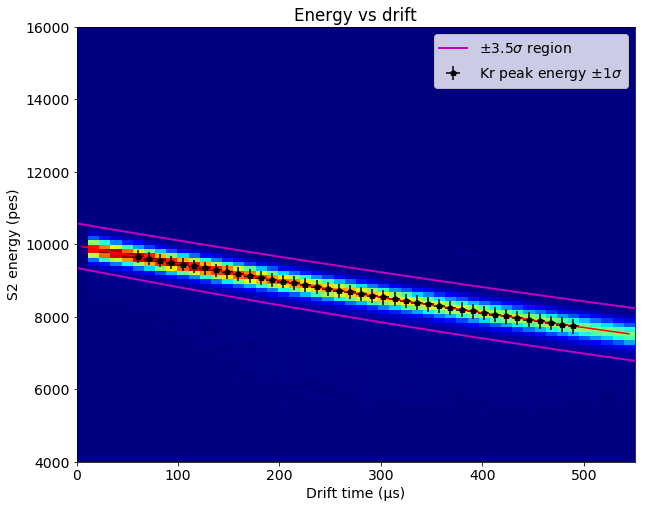

In [16]:
# selection in plot
sel_EvsZ = akr.selection_in_band(E, Z, Erange, Zrange, Zfitrange, nsigma = nsigma, plot=True);
kdstf.selection_info(sel_EvsZ, 'in E vs Z band ')
sel = sel & sel_EvsZ
kdstf.selection_info(sel, 'total selection')

## Distributions

### Kr preselection - Time evolution

In [17]:
Ta   = hst.Vaxis( (TH.min(), TH.max()), 100)
Ea   = hst.Vaxis( (4e3    , 16e3)   , 100)
S1a  = hst.Vaxis( (0.     , 30 )    , 100)
Qa   = hst.Vaxis( (0.     , 1e3)    , 100)

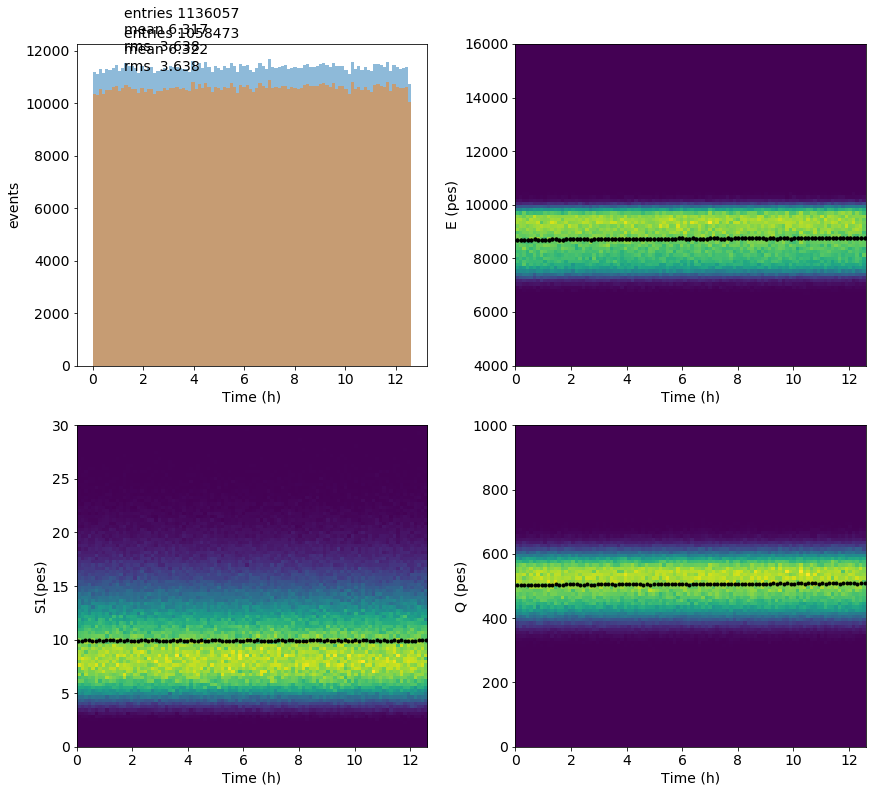

In [18]:
c = hst.Canvas(2, 2)
hst.hist(TH     , Ta.bins, alpha=0.5, canvas = c(1), xylabels = ('Time (h)', 'events'));
hst.hist(TH[sel], Ta.bins, alpha=0.5, canvas = c(1), xylabels = ('Time (h)', 'events'));
#pkr.plt_xdates()

hst.hist2d  (TH[sel], E[sel]  , (Ta.bins, Ea.bins) , canvas = c(2), xylabels = ('Time (h)', 'E (pes)'));
hst.hist2d  (TH[sel], E[sel]  , (Ta.bins, Ea.bins) , canvas = c(2), xylabels = ('Time (h)', 'E (pes)'));
hst.hist2d  (TH[sel], S1e[sel], (Ta.bins, S1a.bins), canvas = c(3), xylabels = ('Time (h)', 'S1(pes)'));
hst.hist2d  (TH[sel], Q[sel]  , (Ta.bins, Qa.bins) , canvas = c(4), xylabels = ('Time (h)', 'Q (pes)'));

hst.hprofile(TH[sel], E[sel]  , (Ta.bins, Ea.bins) , canvas = c(2), fmt = '.', color = 'black');
hst.hprofile(TH[sel], E[sel]  , (Ta.bins, Ea.bins) , canvas = c(2), fmt = '.', color = 'black');
hst.hprofile(TH[sel], S1e[sel], (Ta.bins, S1a.bins), canvas = c(3), fmt = '.', color = 'black');
hst.hprofile(TH[sel], Q[sel]  , (Ta.bins, Qa.bins) , canvas = c(4), fmt = '.', color = 'black');

plt.tight_layout();

### S2, S1 

In [19]:
FEa  = hst.Vaxis( (0., 800e3), 200)
FQa  = hst.Vaxis( (0., 100e3), 200)
FS1a = hst.Vaxis( (0., 300.) , 200)

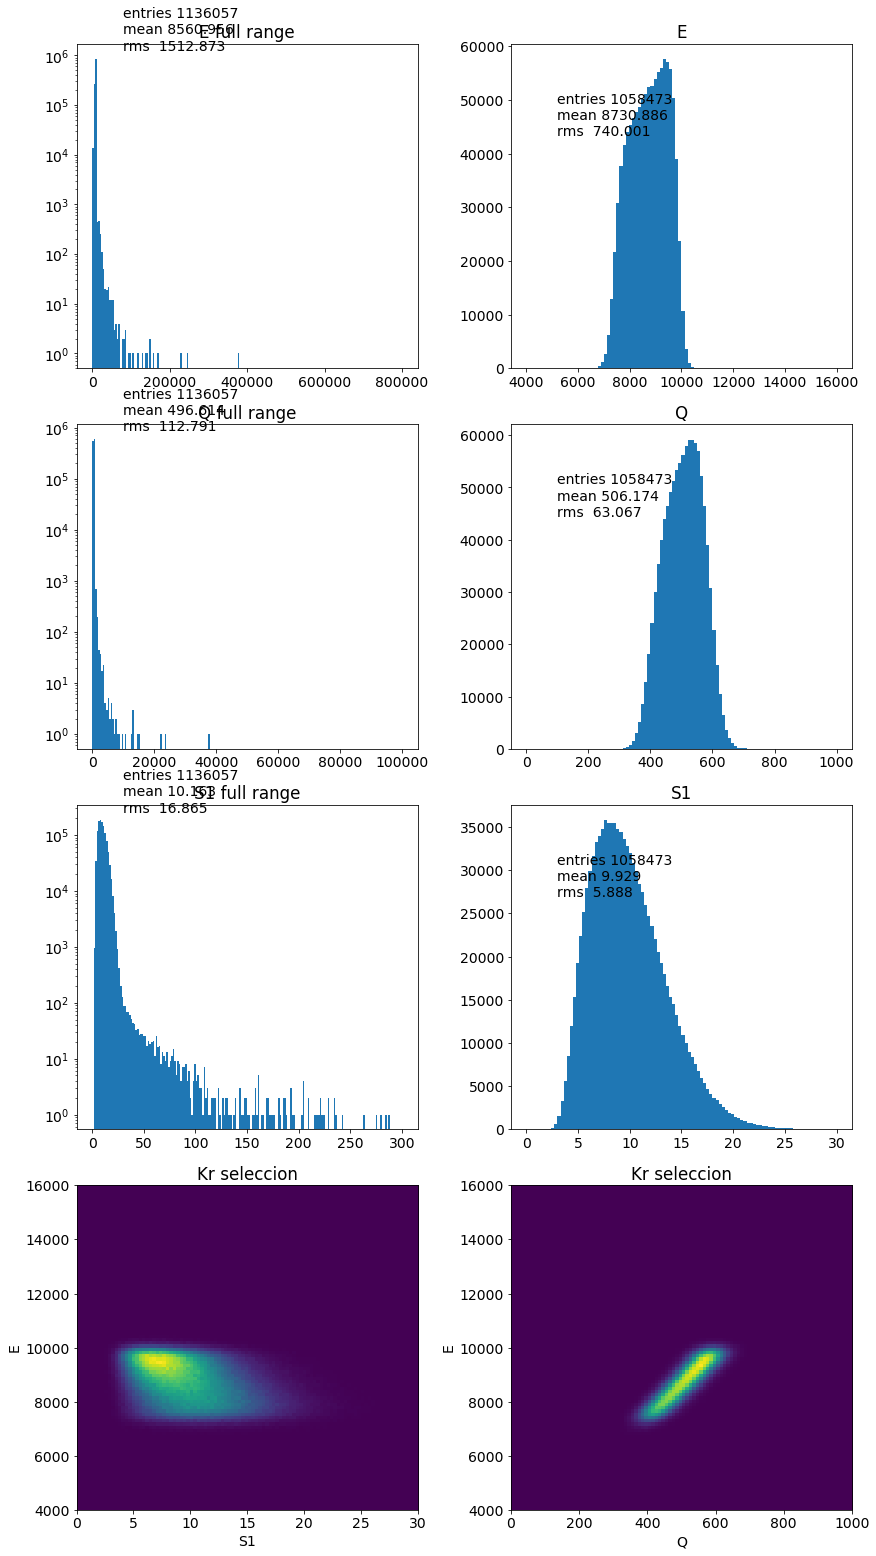

In [20]:
c = hst.Canvas(4, 2)

hst.hist(E       , FEa.bins , canvas = c(1), title = 'E full range', ylog = True)
hst.hist(E[sel]  , Ea.bins  , canvas = c(2), title = 'E');
hst.hist(Q       , FQa.bins , canvas = c(3), title = 'Q full range', ylog = True)
hst.hist(Q[sel]  , Qa.bins  , canvas = c(4), title = 'Q');
hst.hist(S1e     , FS1a.bins, canvas = c(5), title = 'S1 full range', ylog=True)
hst.hist(S1e[sel], S1a.bins , canvas = c(6), title = 'S1');

hst.hist2d  (S1e[sel], E[sel], (S1a.bins, Ea.bins), canvas=c(7), xylabels=('S1', 'E', 'Kr seleccion'))
hst.hist2d  (Q[sel]  , E[sel], (Qa.bins , Ea.bins), canvas=c(8), xylabels=('Q' , 'E', 'Kr seleccion'))
#hst.hprofile(S1e[sel], E[sel], (S1a.bins, Ea.bins), canvas=c(7), fmt='.', color='black')
#hst.hprofile(Q[sel]  , E[sel], (Qa.bins , Ea.bins), canvas=c(8), fmt='.', color='black')

plt.tight_layout()

### X, Y, Z 

In [21]:
XYa = hst.Vaxis((-200., 200,), 100)
Za  = hst.Vaxis((  0.,  550.), 100)

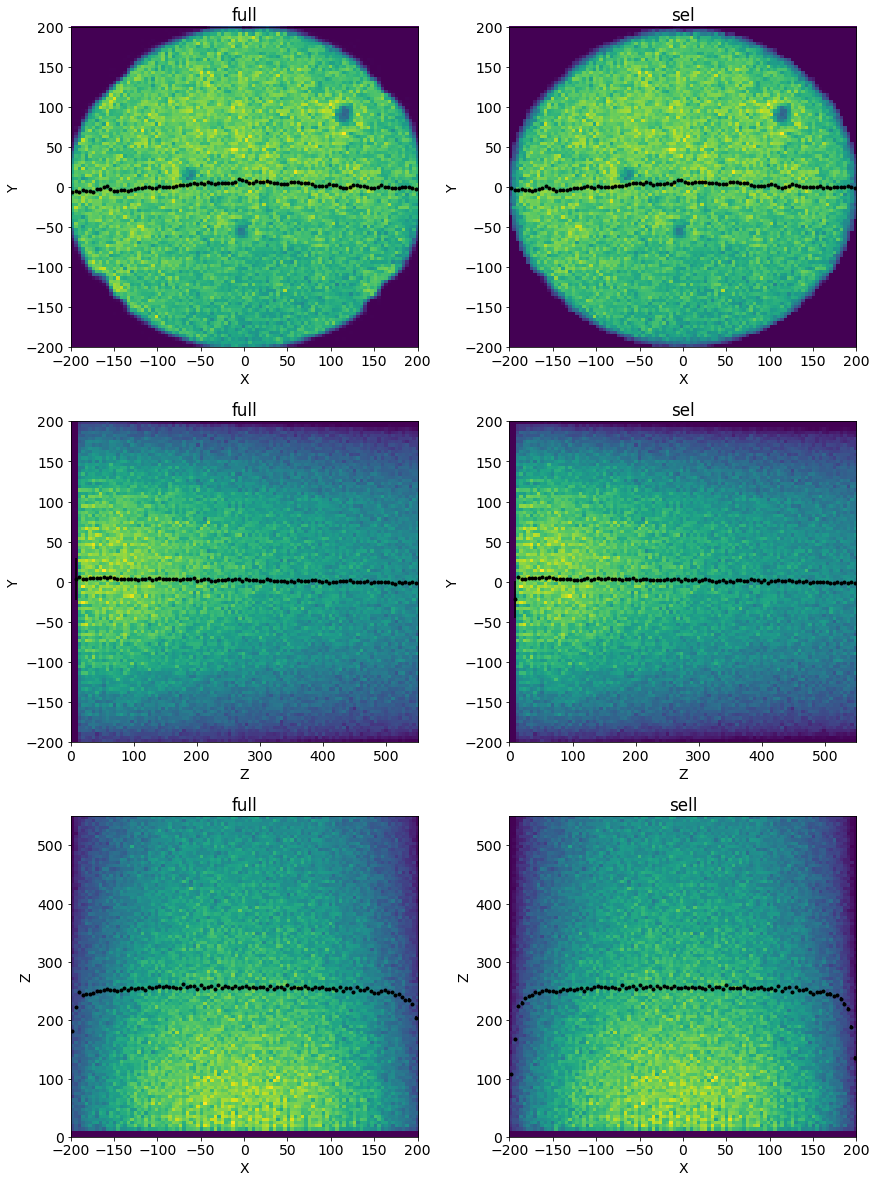

In [22]:
c = hst.Canvas(4, 2)
hst.hist2d  (X     , Y     , (XYa.bins, XYa.bins), canvas = c(1), xylabels = ('X', 'Y', 'full'));
hst.hist2d  (X[sel], Y[sel], (XYa.bins, XYa.bins), canvas = c(2), xylabels = ('X', 'Y', 'sel'));
hst.hprofile(X     , Y     , (XYa.bins, XYa.bins), canvas = c(1), fmt='.', c = 'black');
hst.hprofile(X[sel], Y[sel], (XYa.bins, XYa.bins), canvas = c(2), fmt='.', c = 'black');

hst.hist2d  (Z     , Y     , (Za.bins , XYa.bins), canvas = c(3), xylabels = ('Z', 'Y', 'full'));
hst.hist2d  (Z[sel], Y[sel], (Za.bins , XYa.bins), canvas = c(4), xylabels = ('Z', 'Y', 'sel'));
hst.hprofile(Z     , Y     , (Za.bins , XYa.bins), canvas = c(3), fmt = '.', c = 'black');
hst.hprofile(Z[sel], Y[sel], (Za.bins , XYa.bins), canvas = c(4), fmt = '.', c = 'black');

hst.hist2d  (X     , Z     , (XYa.bins, Za.bins) , canvas = c(5), xylabels = ('X', 'Z', 'full'));
hst.hist2d  (X[sel], Z[sel], (XYa.bins, Za.bins) , canvas = c(6), xylabels = ('X', 'Z', 'sell'));
hst.hprofile(X     , Z     , (XYa.bins, Za.bins) , canvas = c(5), fmt = '.', c = 'black');
hst.hprofile(X[sel], Z[sel], (XYa.bins, Za.bins) , canvas = c(6), fmt = '.', c = 'black');

plt.tight_layout()

In [23]:
Ra   = hst.Vaxis( (0.    , 200. ), 100)
Phia = hst.Vaxis( (-np.pi, np.pi), 100)

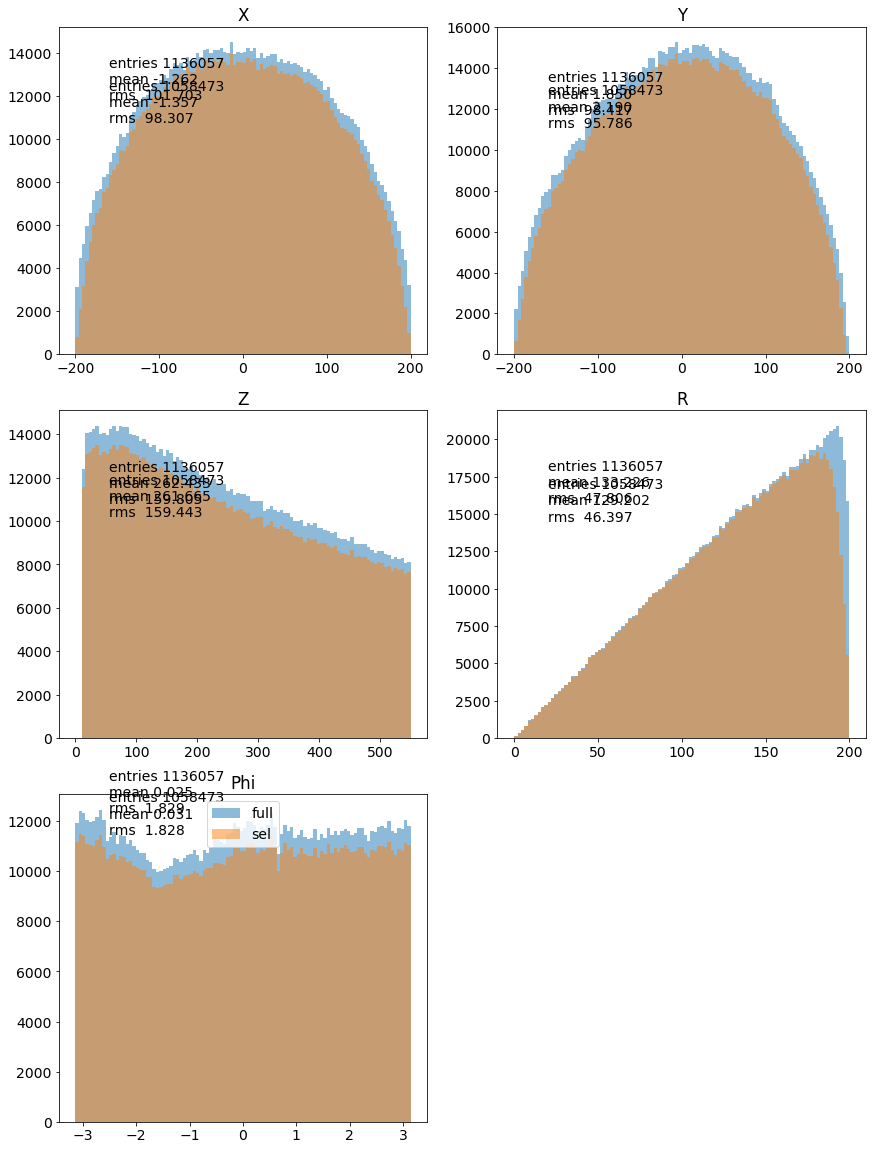

In [24]:
c = hst.Canvas(3, 2)
hst.hist(dst.X  , XYa.bins , alpha=0.5, canvas = c(1), title = 'X'  , label='full')
hst.hist(dst.Y  , XYa.bins , alpha=0.5, canvas = c(2), title = 'Y'  , label='full')
hst.hist(dst.Z  , Za.bins  , alpha=0.5, canvas = c(3), title = 'Z'  , label='full')
hst.hist(dst.R  , Ra.bins  , alpha=0.5, canvas = c(4), title = 'R'  , label='full')
hst.hist(dst.Phi, Phia.bins, alpha=0.5, canvas = c(5), title = 'Phi', label='full');

hst.hist(dst.X[sel]  , XYa.bins , alpha=0.5, canvas = c(1), title = 'X'  , label='sel')
hst.hist(dst.Y[sel]  , XYa.bins , alpha=0.5, canvas = c(2), title = 'Y'  , label='sel')
hst.hist(dst.Z[sel]  , Za.bins  , alpha=0.5, canvas = c(3), title = 'Z'  , label='sel')
hst.hist(dst.R[sel]  , Ra.bins  , alpha=0.5, canvas = c(4), title = 'R'  , label='sel')
hst.hist(dst.Phi[sel], Phia.bins, alpha=0.5, canvas = c(5), title = 'Phi', label='sel');
plt.legend()
plt.tight_layout();

### Charge and SiPM distributions

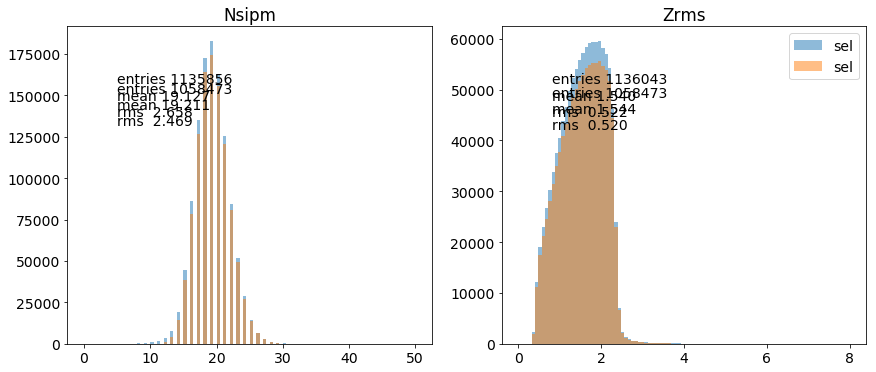

In [25]:
c = hst.Canvas(1, 2)
hst.hist(dst.Nsipm      , 100,  (0, 50) , alpha=0.5, canvas = c(1), title = 'Nsipm', label='full')
hst.hist(dst.Nsipm[sel] , 100,  (0, 50) , alpha=0.5, canvas = c(1), title = 'Nsipm', label='sel')
hst.hist(dst.Zrms       , 100,  (0, 8.), alpha=0.5, canvas = c(2), title = 'Zrms' , label='sel');
hst.hist(dst.Zrms[sel]  , 100,  (0, 8.), alpha=0.5, canvas = c(2), title = 'Zrms' , label='sel');
plt.legend()
plt.tight_layout();

### Comparison between raw and Kr selection

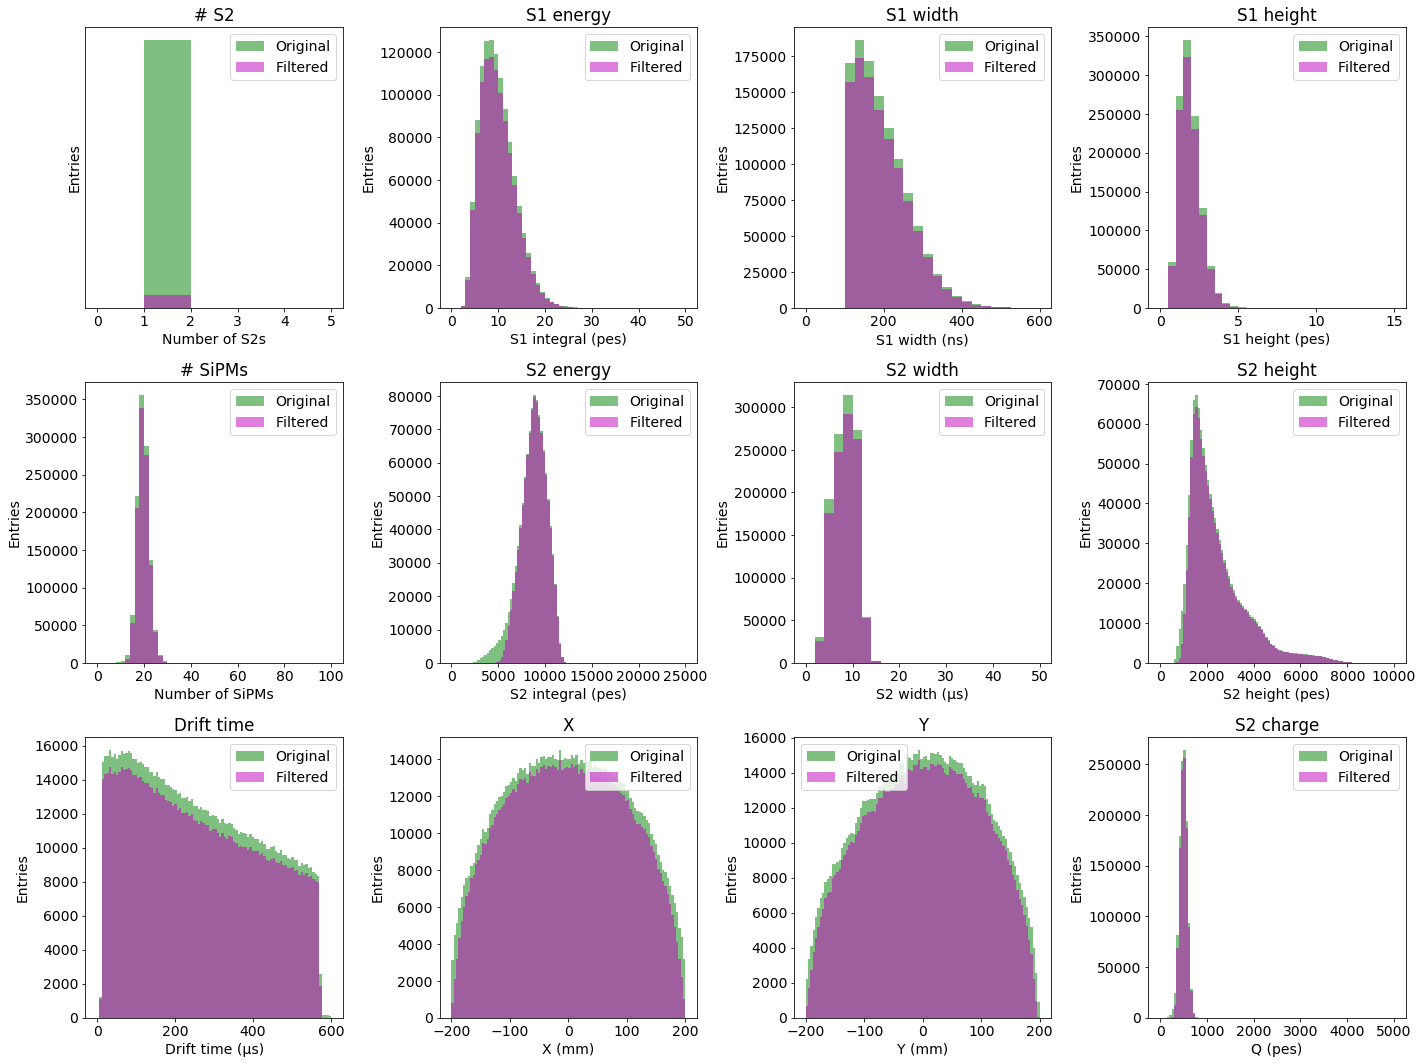

In [26]:
pkr.dst_compare_vars(dst, dst[sel])

In [27]:
if (write_filtered_dst):
    output_dst_filename = os.path.expandvars(output_dst_filename)
    print('writing filtered dst ', output_dst_filename)
    kdstf.kdst_write(dst[sel], output_dst_filename);

writing filtered dst  /Users/hernando/investigacion/NEXT/data/runIV//dsts/kdst_6267_0_filtered.h5


In [28]:
print('Done!')

Done!
